# Deep Learning | Assignment 2 | Part B - Transfer Learning

**README**

- The helper functions at the beginning of the notebook include some of the existing in Part A. 
- The main two pieces of code to perform Transfer Learning are the class named `ImageClassifier`, containing in-built Machine Learning models that can be trained on images' feature maps, and the function `FineTuningRunner`, which allows a whole host of customizable parameters to run experiments using Fine Tuning. 


In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from keras.utils.layer_utils import count_params

import numpy as np
import h5py
import matplotlib.pyplot as plt

# Algorithms for PART B (i) - Feature Extraction 
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from google.colab import drive
from google.colab import files

plt.style.use("default") # Set default layout for matplotlib's charts

print('All modules imported correctly')
print('Running TensorFlow version:', tf.__version__)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


All modules imported correctly
Running TensorFlow version: 2.2.0


In [2]:
# Mounting Google Drive from Colab to access the flowers dataset
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# Unzip and extract the file
!unzip "/content/gdrive/My Drive/Colab Notebooks/data.h5.zip"

Archive:  /content/gdrive/My Drive/Colab Notebooks/data.h5.zip
  inflating: data1.h5                


**Helper functions for this notebook:**

In [0]:
def loadDataH5():
  
  """ This function is given in the assignment spefication document:
  Read training and test data into NumPy arrays from a .h5 file. """

  with h5py.File('data1.h5', 'r') as hf:

    # Extract the data from the .h5 file
    trainX = np.array(hf.get('trainX'))
    trainY = np.array(hf.get('trainY'))
    valX = np.array(hf.get('valX'))
    valY = np.array(hf.get('valY'))

    # Print shape of the arrays
    print('Shape of the training array: \n', trainX.shape)
    print('Shape of the validation array: \n', valX.shape)
  
  return trainX, trainY, valX, valY

def plot_training_data(training_container, n_epochs, save_fig=False):

  """ Visualize the learning curves of a Neural Network.
  Plot up to 5 different metrics.  """
  
  # Get the keys of the container (metrics to be plotted)
  metrics = list(training_container.history.keys())
  # Map metrics to reporting names in charts 
  metrics_mapping = {'loss': 'Training Loss', 'accuracy': 'Training Accuracy', 
                     'val_loss': 'Validation Loss', 'val_accuracy': 'Validation Accuracy'}
  # Support for 5 different colors
  colors = ['dimgray', 'steelblue', 'salmon', 'darkseagreen', 'violet']

  if len(metrics) > 4:
    raise ValueError('This function can only plot up to 4 metrics.')
  
  # Plot a single linechart with all the training metrics
  plt.figure(figsize = (7,6))
  for metric in range(len(metrics)):
    plt.plot(np.arange(0, n_epochs), training_container.history[metrics[metric]], 
             label=metrics_mapping[metrics[metric]], color=colors[metric])
    
  plt.legend()
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")

  if save_fig:
    plt.savefig('training_data.png', dpi=400, bbox_inches='tight')
    files.download('training_data.png')

  plt.show()

def print_best_model(history):

  """ Given a Keras history object, find the model with the lowest 
  validation loss and print level of accuracy and loss. """

  best_model = np.argmin(history.history['val_loss'])
  print('Best model => train loss', round(history.history['loss'][best_model],3))
  print('Best model => train accuracy', round(history.history['accuracy'][best_model],3))
  print('Best model => validation loss', round(history.history['val_loss'][best_model],3))
  print('Best model => validation accuracy', round(history.history['val_accuracy'][best_model],3))

def print_feature_extractor_info(model):

  """ Print relevant information of a given feature exractor """

  print('Model:', model.name)
  print('Depth:', len(model.layers))
  print('Trainable Parameters:', count_params(model.trainable_weights))
  print('Output feature map shape:', model.layers[-1].output_shape[1:])
  print('Total tabular features:', np.prod(model.layers[-1].output_shape[1:]))

def calculate_accuracy(predicted, actual):

  """ Check the level of accuracy given predicted classes and actual labels. """

  bool_acc = tf.math.equal(predicted, actual)
  accuracy = tf.math.divide(tf.math.count_nonzero(bool_acc), actual.shape[0])

  return accuracy.numpy()

**Quick exploratory analysis:**

In [5]:
trainX, trainY, valX, valY = loadDataH5()

Shape of the training array: 
 (1020, 128, 128, 3)
Shape of the validation array: 
 (340, 128, 128, 3)


In [6]:
# Check images are normalized
print("Maximum values of each image's layer: First {f}, Second {s}, Third {t}"\
      .format(f=trainX[:,:,:,0].max(), s=trainX[:,:,:,1].max(), t=trainX[:,:,:,2].max()))
print("Minimum values of each image's layer: First {f}, Second {s}, Third {t}"\
      .format(f=trainX[:,:,:,0].min(), s=trainX[:,:,:,1].min(), t=trainX[:,:,:,2].min()))

Maximum values of each image's layer: First 1.0, Second 1.0, Third 1.0
Minimum values of each image's layer: First 0.0, Second 0.0, Third 0.0


In [7]:
# Store shape
height = trainX.shape[1]
width = trainX.shape[2]
depth = trainX.shape[3]
# There are 17 different classes that are equally distributed in the training set:
unique_classes, count = np.unique(trainY, return_counts=True)
n_classes = len(unique_classes)
print('Number of classes:', n_classes)
print('Class labels: ', unique_classes)
print('Number of training instances per class: ', count)

Number of classes: 17
Class labels:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Number of training instances per class:  [61 64 60 60 64 62 62 59 53 58 57 57 60 57 61 65 60]


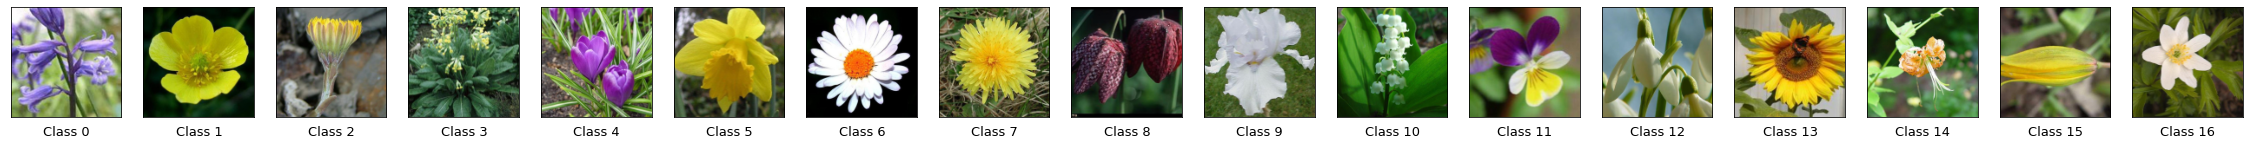

In [8]:
class_examples = []
for class_label in range(0, n_classes):
  class_examples.append(np.random.choice(np.where(trainY == class_label)[0], 1))

# Visualize 17 random images of the training set to get a "feel" of our classification problem
f, position = plt.subplots(1, n_classes, figsize=(40,40))

for image in range(n_classes):
  figure = position[image].\
     imshow(trainX[class_examples[image],:][...,::-1].reshape(128, 128, 3))
  # NumPy arrays are stored as BGR instead of RGB, we reverse this with [...,::-1]
  # Hide axes
  figure.axes.get_xaxis().set_visible(False)
  figure.axes.get_yaxis().set_visible(False)
  # Annotate images with the corresponding class labes
  position[image].\
  text(128/2, 145, 'Class {}'.format(trainY[class_examples[image]][0]), fontsize=13,
       horizontalalignment='center', verticalalignment='center')
  
# Uncomment to save images  
#plt.savefig('flowers_examples.png', dpi=400, bbox_inches='tight')
#files.download('flowers_examples.png')

plt.show()

# PART B (i) - Feature Extraction

In [0]:
class ImageClassifier:

  """ This class helps create an Image Classifier on top of a given feature 
  extractor and evaluate the accuracy of a range of built-in Machine Learning 
  models on train, test, validation or any kind of new data. """

  def __init__(self, feature_extractor):
    
    self.feature_extractor = feature_extractor
    self.rf = RandomForestClassifier(n_estimators=900, random_state=0)
    self.lr = LogisticRegression(C=1, random_state=0, verbose=0)
    self.svc = SVC(C=1, random_state=0)
    self.knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='distance')
    self.nb = GaussianNB()
    self.scaler = StandardScaler()
    self.norm = False
    self.classifiers = {'Random Forest': self.rf,
                       'Logistic Regression': self.lr,
                       'Support Vector Machine': self.svc,
                       'K-Nearest Neighbors': self.knn,
                       'Naive Bayes': self.nb}

  def create_features(self, x, normalize):

    """ Use the feature extractor to predict on a set of images
    and preprocess the resulting feature map to make it readable by
    Machine Learning models. """

    # Predict on image data 
    feature_map = self.feature_extractor.predict(x)
    # Convert feature map into a tabular dataset (array)
    feature_data = feature_map.reshape(feature_map.shape[0], -1)
    # If norm is set to True, a scaler has been already fit
    if self.norm:
      feature_data = self.scaler.transform(feature_data)
    else:
      if normalize: 
        # If the scaler isn't fit yet and it's required then fit
        self.norm = normalize
        feature_data = self.scaler.fit_transform(feature_data)
      else: 
        # Otherwise do not normalize the data
        pass

    return feature_data

  def train_classifiers(self, x, y, normalize_data):

    """ Train a selection of Machine Learning models using extracted features
    from images. """

    # Create dataset for Machine Learning models
    train_x = self.create_features(x, normalize_data)
    # Fit every model
    self.rf.fit(train_x, y)
    self.lr.fit(train_x, y)
    self.svc.fit(train_x, y)
    self.knn.fit(train_x, y)
    self.nb.fit(train_x, y)

    print('All models fitted successfully.')

  def evaluate(self, x, y, classifier):

    """ Evaluate the level of accuracy of a specific Machine Learning model
     passed as an argument. """

    # Extract features
    feature_data = self.create_features(x, self.norm)
    # Predict
    pred = self.classifiers[classifier].predict(feature_data)
    # Evaluate
    accuracy = calculate_accuracy(pred, y)
    
    return accuracy

## Feature Extractor: VGG16

In [113]:
# Load feature extractor using ImageNet weights
vgg16Model= tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(height, width, depth))
print('## Model loaded ##')
print_feature_extractor_info(vgg16Model)

## Model loaded ##
Model: vgg16
Depth: 19
Trainable Parameters: 14714688
Output feature map shape: (4, 4, 512)
Total tabular features: 8192


In [104]:
# Show keras' summary
vgg16Model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [107]:
# Create an instance of the image classifier
vgg_classifier = ImageClassifier(feature_extractor=vgg16Model)
# Train a host of classifiers using feature extractor's feature map
vgg_classifier.train_classifiers(trainX, trainY, normalize_data=True)
# Examine implemented classifiers
vgg_classifier.classifiers.keys()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


All models fitted successfully.


dict_keys(['Random Forest', 'Logistic Regression', 'Support Vector Machine', 'K-Nearest Neighbors', 'Naive Bayes'])

In [108]:
# Evaluate classifiers on validation data
print('Evaluating accuracy on the validation set...')
for model in vgg_classifier.classifiers.keys():
  accuracy = vgg_classifier.evaluate(valX, valY, model)
  print(model, round(accuracy,3))

Evaluating accuracy on the validation set...
Random Forest 0.85
Logistic Regression 0.876
Support Vector Machine 0.712
K-Nearest Neighbors 0.521
Naive Bayes 0.371


## Feature Extractor: InceptionV3

In [112]:
# Load feature extractor using ImageNet weights
inceptionModel = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(height, width, depth))
print('## Model loaded ##')
print_feature_extractor_info(inceptionModel)

## Model loaded ##
Model: inception_v3
Depth: 311
Trainable Parameters: 21768352
Output feature map shape: (2, 2, 2048)
Total tabular features: 8192


In [110]:
# Show keras' summary
inceptionModel.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_38[0][0]                   
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization_20[0][0]     
_______________________________________________________________________________________

In [44]:
# Create an instance of the image classifier
inception_classifier = ImageClassifier(feature_extractor=inceptionModel)
# Train a host of classifiers using feature extractor's feature map
inception_classifier.train_classifiers(trainX, trainY, normalize_data=True)
# Examine implemented classifiers
inception_classifier.classifiers.keys()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


All models fitted successfully.


dict_keys(['Random Forest', 'Logistic Regression', 'Support Vector Machine', 'K-Nearest Neighbors', 'Naive Bayes'])

In [46]:
# Evaluate classifiers on validation data
print('Evaluating accuracy on the validation set...')
for model in inception_classifier.classifiers.keys():
  accuracy = inception_classifier.evaluate(valX, valY, model)
  print(model, round(accuracy,3))

Evaluating accuracy on the validation set...
Random Forest 0.821
Logistic Regression 0.853
Support Vector Machine 0.812
K-Nearest Neighbors 0.671
Naive Bayes 0.676


## Feature Extractor: MobileNet

In [114]:
# Load feature extractor using ImageNet weights
mobilenetModel = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(height, width, depth))
print('## Model loaded ##')
print_feature_extractor_info(mobilenetModel)

## Model loaded ##
Model: mobilenet_1.00_128
Depth: 87
Trainable Parameters: 3206976
Output feature map shape: (4, 4, 1024)
Total tabular features: 16384


In [115]:
# Show keras' summary
mobilenetModel.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32) 

In [48]:
# Create an instance of the image classifier
mobile_classifier = ImageClassifier(feature_extractor=mobilenetModel)
# Train a host of classifiers using feature extractor's feature map
mobile_classifier.train_classifiers(trainX, trainY, normalize_data=True)
# Examine implemented classifiers
mobile_classifier.classifiers.keys()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


All models fitted successfully.


dict_keys(['Random Forest', 'Logistic Regression', 'Support Vector Machine', 'K-Nearest Neighbors', 'Naive Bayes'])

In [49]:
# Evaluate classifiers on validation data
print('Evaluating accuracy on the validation set...')
for model in mobile_classifier.classifiers.keys():
  accuracy = mobile_classifier.evaluate(valX, valY, model)
  print(model, round(accuracy,3))

Evaluating accuracy on the validation set...
Random Forest 0.926
Logistic Regression 0.953
Support Vector Machine 0.9
K-Nearest Neighbors 0.682
Naive Bayes 0.606


## Feature Extractor: Xception

In [118]:
# Load feature extractor using ImageNet weights
xceptionModel = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(height, width, depth))
print('## Model loaded ##')
print_feature_extractor_info(xceptionModel)

## Model loaded ##
Model: xception
Depth: 132
Trainable Parameters: 20806952
Output feature map shape: (4, 4, 2048)
Total tabular features: 32768


In [117]:
# Show keras' summary
xceptionModel.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_43[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [51]:
# Create an instance of the image classifier
xception_classifier = ImageClassifier(feature_extractor=xceptionModel)
# Train a host of classifiers using feature extractor's feature map
xception_classifier.train_classifiers(trainX, trainY, normalize_data=True)
# Examine implemented classifiers
xception_classifier.classifiers.keys()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


All models fitted successfully.


dict_keys(['Random Forest', 'Logistic Regression', 'Support Vector Machine', 'K-Nearest Neighbors', 'Naive Bayes'])

In [52]:
# Evaluate classifiers on validation data
print('Evaluating accuracy on the validation set...')
for model in xception_classifier.classifiers.keys():
  accuracy = xception_classifier.evaluate(valX, valY, model)
  print(model, round(accuracy,3))

Evaluating accuracy on the validation set...
Random Forest 0.788
Logistic Regression 0.812
Support Vector Machine 0.718
K-Nearest Neighbors 0.656
Naive Bayes 0.365


# PART B (ii) - Fine Tuning

In this section we have run 16 different configurations. We consider that putting all these experiments in different cells could make this part a little bit unclear. Hence, we deem it appropriate to give a couple of examples and instructions around the usage of the code, and then let the end-user try different configurations. Below are the ones we tried (this is documented and further discussed in the report):

Configurations
--------------------------------------------------
-------------------------------------------------
**VGG16 & MobileNet**  
- VGG16 + Adam  
- VGG16 + SGD  
- VGG16 + Adam + Batch Normalization  
- VGG16 + SGD + Batch Normalization  
- VGG16 + Adam + Dropout  
- VGG16 + SGD + Dropout  
- VGG16 + Adam + Batch Normalization + Dropout  
- VGG16 + SGD + Batch Normalization + Dropout   
- MobileNet + Adam  
- MobileNet + SGD  
- MobileNet + Adam + Batch Normalization  
- MobileNet + SGD + Batch Normalization  
- MobileNet + Adam + Dropout  
- MobileNet + SGD + Dropout  
- MobileNet + Adam + Batch Normalization + Dropout *(Best performing model)*  
- MobileNet + SGD + Batch Normalization + Dropout  

In [0]:
def FineTuningRunner(exp_config, arch_config, feature_extractor, train_from):

  """ Experiment runner for Fine Tuning. It takes two dictionaries to configure
  a fully connected neural network and the two phases. The feature extractor 
  and the layer from which the extractor is tunable are passed as arguments. """

  # Create an instance of the feature extractor
  extractor = feature_extractor
  # Initially set to False during the first phase
  extractor.trainable = False
  
  # Create a Sequential model on top of the extractor
  model = tf.keras.models.Sequential()
  model.add(extractor)
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=arch_config['hidden_units'], 
                                  activation='relu'))  
  if arch_config['dropout']: # Config
    model.add(tf.keras.layers.Dropout(0.50))  
  if arch_config['batch_norm']: # Config
    model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(units=arch_config['output_units'], 
                                  activation='softmax'))
  
  print("Starting Phase A of training...")
  # Create an instance of the model based on the architecture config dict
  optimizer = arch_config['optimizer']
  # Update optimizer's learning rate to Phase A
  optimizer.learning_rate = exp_config['lr_a']
  # Apply the changes by compiling the model
  model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
  # Run Phase A of training
  phase_a = model.fit(exp_config['x_train'], exp_config['y_train'], 
        epochs=exp_config['epochs_a'], batch_size=exp_config['batch_size'],       
        validation_data=(exp_config['x_val'], exp_config['y_val'])
        )

  print("Starting Phase B of training...")
  # Update learning rate for Phase B - usually smaller rate
  optimizer.learning_rate = exp_config['lr_b']
  # Set specific extractor's layers to be trainable 
  extractor.trainable = True
  trainableFlag = False
  for layer in extractor.layers:
    # Starting from `train_from`, all the subsequent layers can be trained
    if layer.name == train_from:
      trainableFlag = True
    layer.trainable = trainableFlag
  # Recompile model so that the changes in layers and lr take effect   
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  # Run Phase B of training
  phase_b = model.fit(exp_config['x_train'], exp_config['y_train'], 
        epochs=exp_config['epochs_b'], batch_size=exp_config['batch_size'],       
        validation_data=(exp_config['x_val'], exp_config['y_val'])
        )

  return phase_a, phase_b

Default configuration of the experiments. Note we differentiate between Phase A and B for epochs and learning rate.

In [0]:
exp_config = {'x_train': trainX,
             'y_train': trainY,
             'x_val': valX,
             'y_val': valY,
             'epochs_a': 25,
             'epochs_b': 50,
             'lr_a': 0.001,
             'lr_b': 0.0001,
             'batch_size': 32}

Default configuration of the fully connected neural network architecture. It only has one hidden layer by default (enough to solve this classification problem).

In [0]:
arch_config = {'hidden_units': 512,
              'output_units': 17,
              'dropout': False,
              'batch_norm': True,
              'optimizer': None}

Parameters can be updated directly in the dictionaries or you can override their values. For instance, the following is valid:

In [0]:
arch_config['optimizer'] = tf.keras.optimizers.Adam()

# Example 1: VGG + SGD + Batch Normalization

In [94]:
# Create an instance of the extractor
extractor = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(height, width, depth))
# Set the optimizer in the config dict 
arch_config['optimizer'] = tf.keras.optimizers.SGD()
# Enable bacth normalization 
arch_config['batch_norm'] = True
# Execute the runner by passing the config dictionaries, extractor and the layer
# from which the feature extractor can be trained 
ha, hb = FineTuningRunner(exp_config, arch_config, extractor, 'block4_conv1')

Starting Phase A of training...
Epoch 1/25
32/32 [==============================] - 2s 73ms/step - loss: 2.6351 - accuracy: 0.2216 - val_loss: 2.4846 - val_accuracy: 0.2382
Epoch 2/25
32/32 [==============================] - 2s 67ms/step - loss: 1.7008 - accuracy: 0.5088 - val_loss: 2.1359 - val_accuracy: 0.3912
Epoch 3/25
32/32 [==============================] - 2s 67ms/step - loss: 1.2884 - accuracy: 0.6412 - val_loss: 1.8445 - val_accuracy: 0.5412
Epoch 4/25
32/32 [==============================] - 2s 67ms/step - loss: 1.0375 - accuracy: 0.7196 - val_loss: 1.6098 - val_accuracy: 0.6000
Epoch 5/25
32/32 [==============================] - 2s 67ms/step - loss: 0.8687 - accuracy: 0.7853 - val_loss: 1.4108 - val_accuracy: 0.6794
Epoch 6/25
32/32 [==============================] - 2s 68ms/step - loss: 0.7535 - accuracy: 0.8343 - val_loss: 1.2522 - val_accuracy: 0.7176
Epoch 7/25
32/32 [==============================] - 2s 68ms/step - loss: 0.6367 - accuracy: 0.8627 - val_loss: 1.1285 - va

Phase A
Best model => train loss 0.161
Best model => train accuracy 0.997
Best model => validation loss 0.658
Best model => validation accuracy 0.794


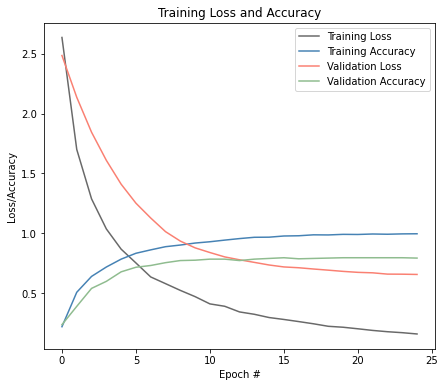

In [96]:
# Print Phase A results
print('Phase A')
print_best_model(ha)
plot_training_data(ha, n_epochs=exp_config['epochs_a'], save_fig=False)

Phase B
Best model => train loss 0.064
Best model => train accuracy 1.0
Best model => validation loss 0.544
Best model => validation accuracy 0.838


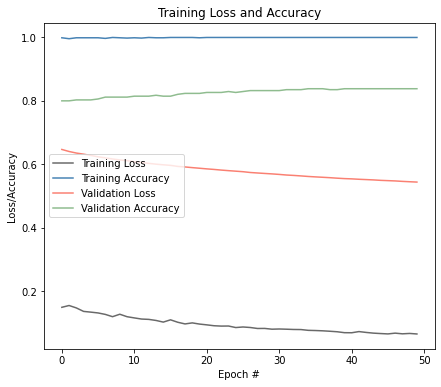

In [97]:
# Print Phase B results
print('Phase B')
print_best_model(hb)
plot_training_data(hb, n_epochs=exp_config['epochs_b'], save_fig=False)

# Example 2: MobileNet + Adam + Batch Normalization + Dropout
*This was the best performing model*

In [99]:
# Create an instance of the extractor
extractor = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(height, width, depth))
# Set the optimizer in the config dict 
arch_config['optimizer'] = tf.keras.optimizers.Adam()
# Enable bacth normalization 
arch_config['batch_norm'] = True
# Enable dropout
arch_config['dropout'] = True
# Execute the runner by passing the config dictionaries, extractor and the layer
# from which the feature extractor can be trained 
ha, hb = FineTuningRunner(exp_config, arch_config, extractor, 'conv_pw_11')

Starting Phase A of training...
Epoch 1/25
32/32 [==============================] - 1s 34ms/step - loss: 1.0911 - accuracy: 0.6833 - val_loss: 0.2749 - val_accuracy: 0.9265
Epoch 2/25
32/32 [==============================] - 1s 20ms/step - loss: 0.1847 - accuracy: 0.9578 - val_loss: 0.1885 - val_accuracy: 0.9353
Epoch 3/25
32/32 [==============================] - 1s 20ms/step - loss: 0.0785 - accuracy: 0.9892 - val_loss: 0.2054 - val_accuracy: 0.9294
Epoch 4/25
32/32 [==============================] - 1s 20ms/step - loss: 0.0348 - accuracy: 0.9990 - val_loss: 0.2079 - val_accuracy: 0.9235
Epoch 5/25
32/32 [==============================] - 1s 20ms/step - loss: 0.0237 - accuracy: 0.9990 - val_loss: 0.1840 - val_accuracy: 0.9324
Epoch 6/25
32/32 [==============================] - 1s 20ms/step - loss: 0.0182 - accuracy: 0.9990 - val_loss: 0.1767 - val_accuracy: 0.9353
Epoch 7/25
32/32 [==============================] - 1s 20ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.1697 - va

Phase A
Best model => train loss 0.002
Best model => train accuracy 1.0
Best model => validation loss 0.152
Best model => validation accuracy 0.938


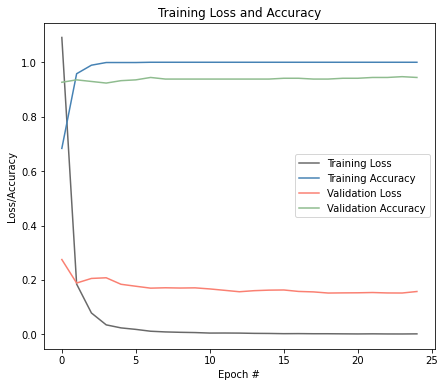

In [100]:
# Print Phase A results
print('Phase A')
print_best_model(ha)
plot_training_data(ha, n_epochs=exp_config['epochs_a'], save_fig=False)

Phase B
Best model => train loss 0.001
Best model => train accuracy 1.0
Best model => validation loss 0.12
Best model => validation accuracy 0.959


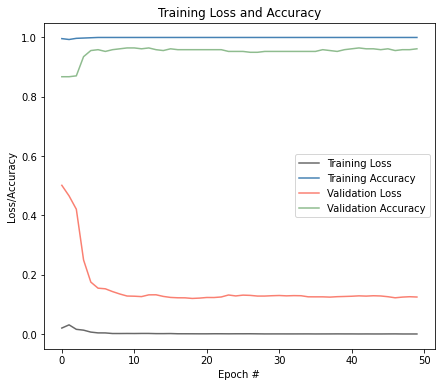

In [102]:
# Print Phase B results
print('Phase B')
print_best_model(hb)
plot_training_data(hb, n_epochs=exp_config['epochs_b'], save_fig=False)